#  Project

**Project Goal:** 

**Dataset Period:**

**Methodology:** 

---

## 1. Business Understanding

### 1.1 Business Objectives
TODO

### 1.2 Project Goals and Successs Criteria
TODO


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    BaggingRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from statsmodels.tsa.seasonal import STL
import math
from statsmodels.nonparametric.smoothers_lowess import lowess
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats


---
## 2. Data Understanding

### 2.1 Data Collection

The first step is to load the datasets into the working environment. This involves importing the necessary libraries and reading the data file into a suitable data structure, namely, a DataFrame using Pandas.

In [58]:
# Load datasets
weather = pd.read_csv("weather.csv", parse_dates=["time"])
energy = pd.read_csv("energy_dataset.csv", parse_dates=["time"])

# Set 'time' as index
weather = weather.set_index("time")
energy = energy.set_index("time")

### 2.2 Data Description

##### Basic dataset information

In [59]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35045 non-null  float64
 1   generation_fossil_brown_coal_lignite         35046 non-null  float64
 2   generation_fossil_coal-derived_gas           35046 non-null  float64
 3   generation_fossil_gas                        35046 non-null  float64
 4   generation_fossil_hard_coal                  35046 non-null  float64
 5   generation_fossil_oil                        35045 non-null  float64
 6   generation_fossil_oil_shale                  35046 non-null  float64
 7   generation_fossil_peat                       35046 non-null  float64
 8   generation_geothermal                        35046 non-null  float64
 9   generation_hydro_pumped_storage_a

The *energy* dataset contains 35064 entries and 24 features, representing hourly records of electricity generation from various sources, total system load, and the day-ahead market price. Each row corresponds to one hour of energy system operation, and the goal is to forecast the electricity price one hour and one day ahead.

In [60]:
energy.describe()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,...,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,...,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,0.0,35028.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,...,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,NaN,28696.939905,49.874341
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,...,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,NaN,4574.987950,14.618900
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,18041.000000,2.060000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,...,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,NaN,24807.750000,41.490000
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,...,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,NaN,28901.000000,50.520000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,...,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,NaN,32192.000000,60.530000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,...,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,NaN,41015.000000,101.990000


In [61]:
energy.head()

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_coal-derived_gas,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_fossil_oil_shale,generation_fossil_peat,generation_geothermal,generation_hydro_pumped_storage_aggregated,...,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_offshore,generation_wind_onshore,forecast_wind_offshore_eday_ahead,total_load_actual,price_day_ahead
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,NaN,25385.0,50.10
2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,NaN,24382.0,48.10
2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,NaN,22734.0,47.33
2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,...,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,NaN,21286.0,42.27
2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,...,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,NaN,20264.0,38.41


In [62]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2015-01-01 00:00:00+01:00 to 2018-12-31 23:00:00+01:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  35064 non-null  float64
 1   pressure     35064 non-null  float64
 2   humidity     35064 non-null  float64
 3   wind_speed   35064 non-null  float64
dtypes: float64(4)
memory usage: 1.3+ MB


The *weather* dataset also contains 35064 entries and 5 features representing hourly meteorological measurements such as temperature, pressure, humidity, and wind speed. Each row corresponds to one hour of weather conditions, and these variables are used as exogenous inputs to improve electricity price forecasting.

In [63]:
weather.describe()

,temperature,pressure,humidity,wind_speed
count,35064.000000,35064.000000,35064.000000,35064.000000
mean,289.706862,1017.297872,68.033025,2.442944
std,7.251796,6.363845,14.814871,1.276415
min,272.006000,999.500000,22.600000,0.000000
25%,284.098877,1013.475000,56.750000,1.400000
50%,289.036200,1017.000000,69.600000,2.200000
75%,295.100500,1021.000000,80.000000,3.200000
max,309.048000,1035.500000,100.000000,8.500000


In [64]:
weather.head()

,temperature,pressure,humidity,wind_speed
time,,,,
2015-01-01 00:00:00+01:00,272.491463,1021.3,82.4,2.0
2015-01-01 01:00:00+01:00,272.512700,1021.2,82.4,2.0
2015-01-01 02:00:00+01:00,272.151937,1021.6,82.0,2.4
2015-01-01 03:00:00+01:00,272.142269,1021.5,82.0,2.4
2015-01-01 04:00:00+01:00,272.198700,1021.5,82.0,2.4


### 2.3 Data Exploration

#### 2.3.1 Target variable analysis

The target variable `price_day_ahead` represents the eletricity market price for the upcoming hour.

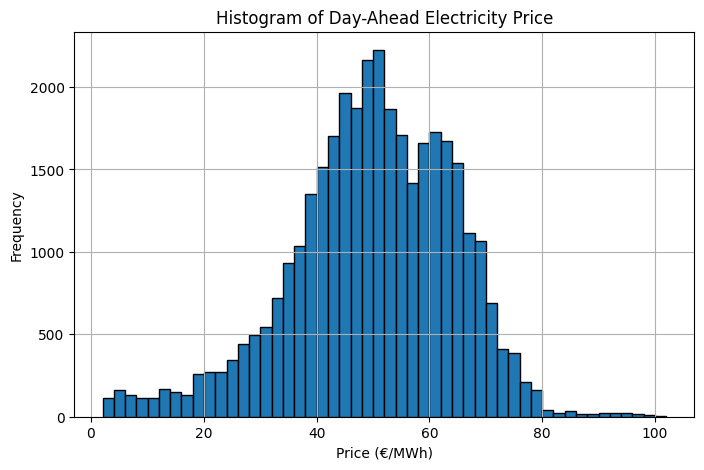

In [65]:
target_col='price_day_ahead'

plt.figure(figsize=(8,5))
plt.hist(energy[target_col], bins=50, edgecolor='black')
plt.title("Histogram of Day-Ahead Electricity Price")
plt.xlabel("Price (€/MWh)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

The histogram shows a distribution that is very close to a normal distribution, although it is slightly right-skewed.

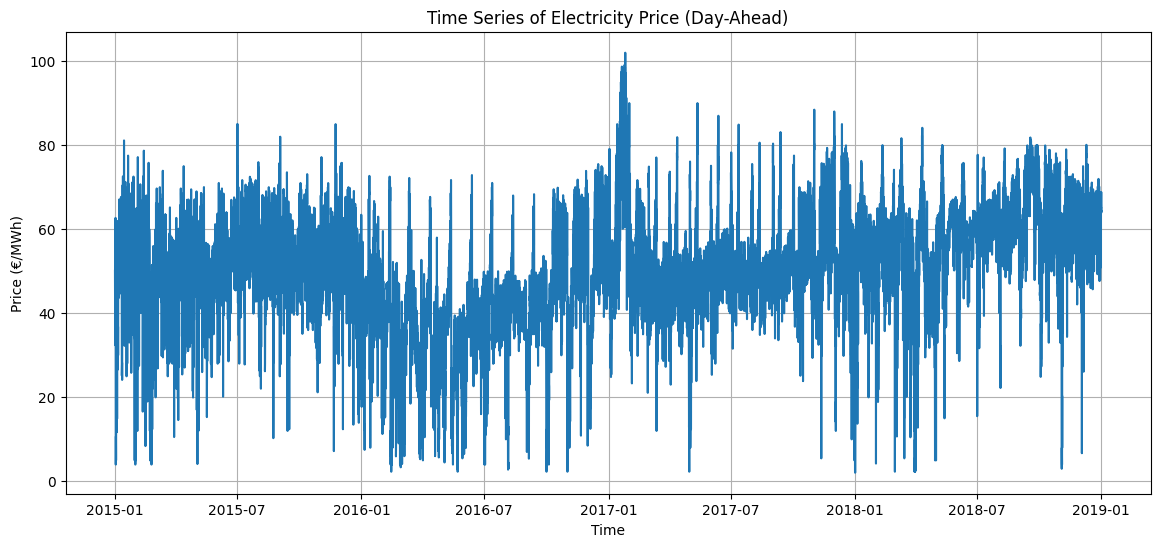

In [66]:
plt.figure(figsize=(14, 6))
plt.plot(energy[target_col])
plt.title("Time Series of Electricity Price (Day-Ahead)")
plt.xlabel("Time")
plt.ylabel("Price (€/MWh)")
plt.grid(True)
plt.show()

The time series plot shows strong short-term fluctuations and clear seasonal patterns, with occasional price spikes. Prices vary over time, indicating non-stationarity and the presence of both volatility and periodic behavior.

#### 2.3.2 Feature distribution analysis

Now we will perform feature distribution analysis to examine how the data values are spread across the datasets. We will use plots and histograms to visualise the distributions features. Box plots for will be skipped in this step, as they will be specifically used for outlier detection in paragraph `2.4.2`.

In [67]:
def feat_distribution(nonDiscreteFeatures, df):
    nrows = math.ceil(len(nonDiscreteFeatures) / 2)
    ncols = 2
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, nrows * 5))
    axes = axes.flatten()

    for i, col in enumerate(nonDiscreteFeatures):
        df[col].hist(bins=30, ax=axes[i])
        axes[i].set_title(f'{col} Distribution')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.show()

All of the features are numerical and continuous.

##### Energy dataset

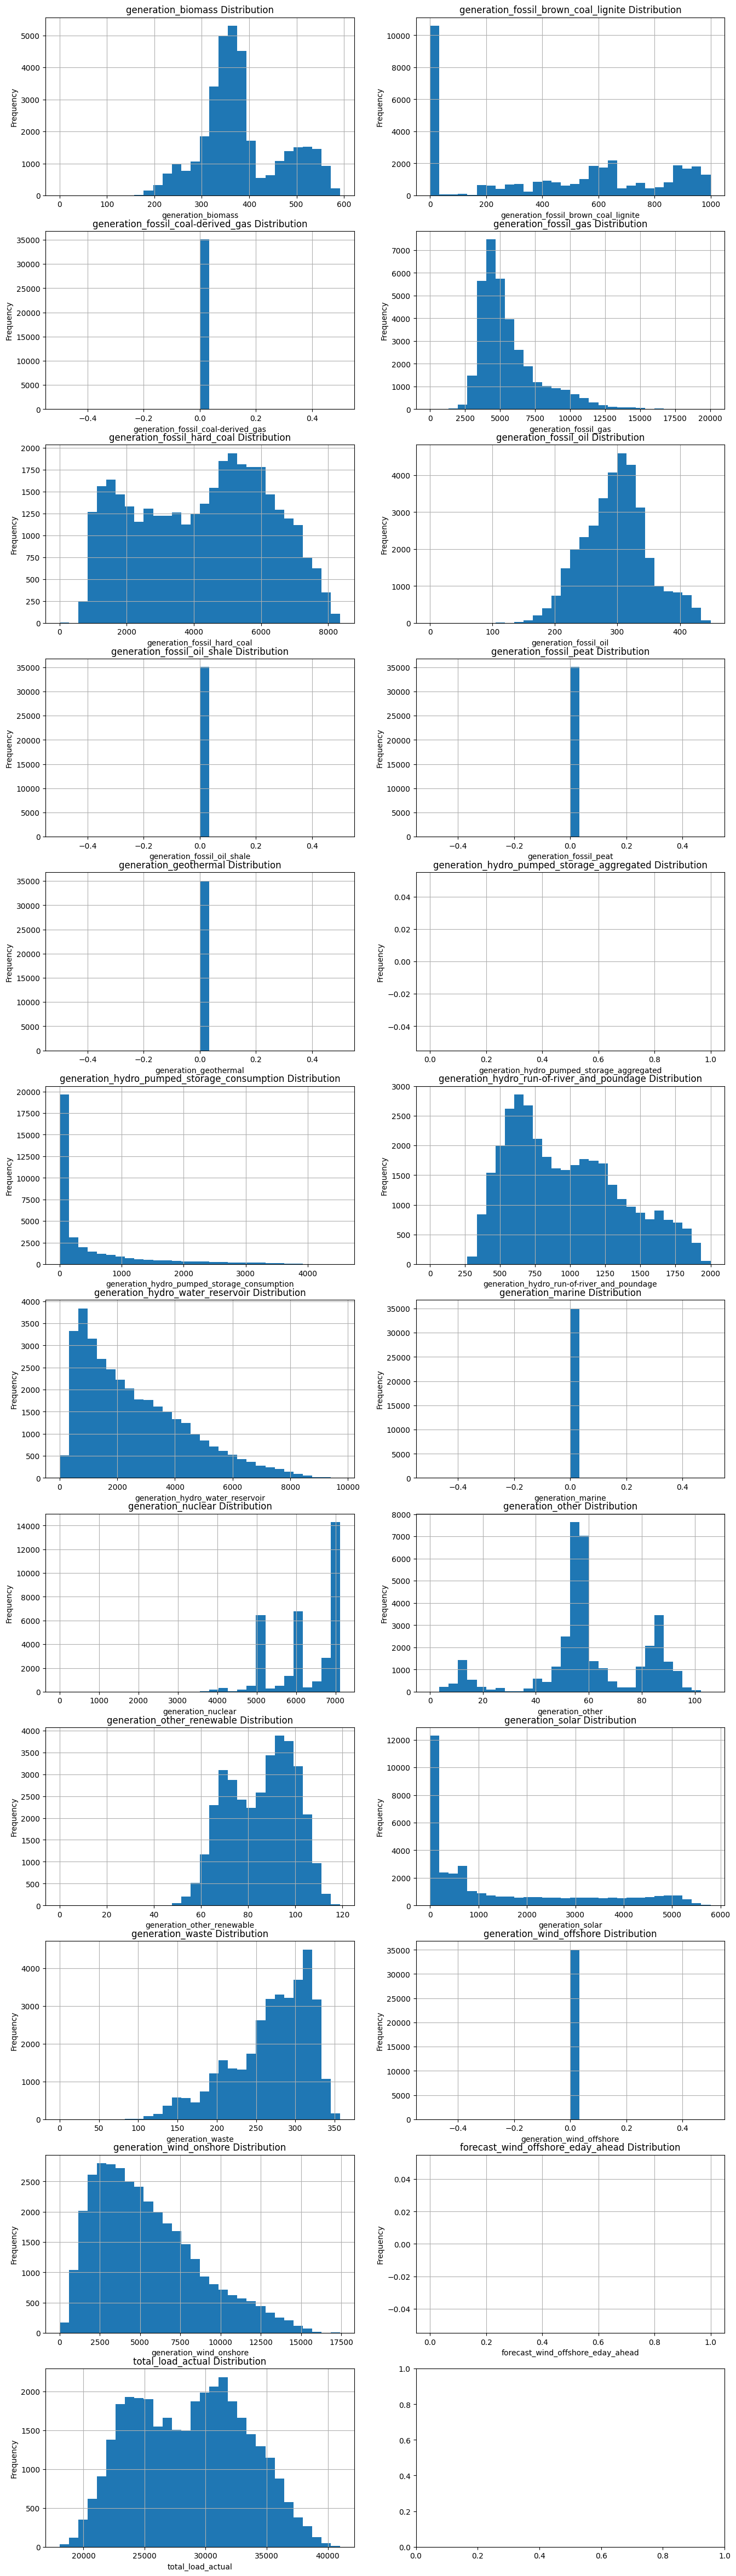

In [68]:
energy_features = [col for col in energy.columns 
                   if col not in ['time', 'price_day_ahead']]
feat_distribution(energy_features, energy)

None of the features has a normal distribution. `generation_hydro_pumped_storage_consumption`, `generation_hydro_water_reservoir`, and `generation_solar` are strongly right-skewed, while `generation_wind_onshore` is moderately right-skewed. In contrast, `generation_waste` is left-skewed.
Variables with skewed distributions will be handled in paragraph 3.4.3, because skewness can negatively affect the models used later in paragraph 4.2, particularly KNN, SVR, and Linear Regression, which rely on distance metrics or assumptions of linearity.

`generation_marine`, `generation_geothermal`, `generation_fossil_oil_shale`, `generation_fossil_peat`, and `generation_fossil_coal-derived_gas` contain only zeros, which is consistent with the dataset description provided in paragraph 2.2.

The data represented by the remaining variables generally show irregular, multimodal, or heavily skewed shapes, reflecting the diverse and highly variable nature of electricity generation across different sources.

##### Weather dataset

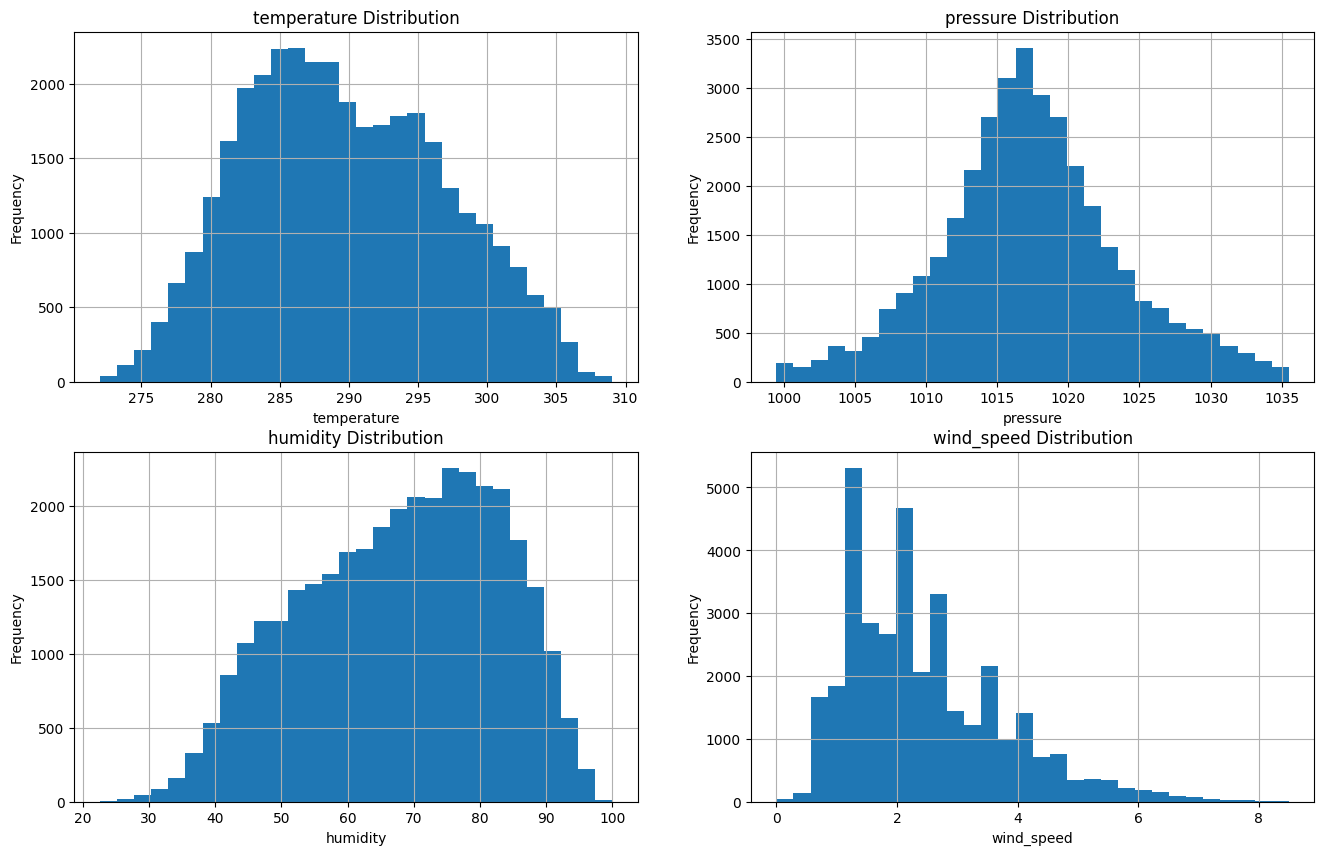

In [69]:
weather_features = [col for col in weather.columns if col != 'time']
feat_distribution(weather_features, weather)

`temperature` and `pressure` distribution is close to normal, whereas `humidity` is slightly left-skewed and `wind_speed` is right-skewed.

Skeweness will be handled in paragraph DOK

In [70]:
skewed_cols = ['generation_hydro_pumped_storage_consumption','generation_hydro_water_reservoir','generation_solar','generation_wind_onshore','generation_waste','wind_speed']

### 2.4 Data Quality Assessment

#### 2.4.1 Identify missing values

In the first place, we will check for missing values to ensure data completeness and avoid potential issues during analysis and modeling.

In [71]:
# % missing values by column

def missing_values_info(df):
    nulls = df.isnull().sum()
    percent = round(nulls / df.shape[0] * 100, 3)
    
    nullvalues = pd.concat([nulls, percent], axis=1)
    nullvalues.columns = ["Count", "%"]
    
    return nullvalues


In [72]:
missing_values_info(energy)

,Count,%
generation_biomass,19,0.054
generation_fossil_brown_coal_lignite,18,0.051
generation_fossil_coal-derived_gas,18,0.051
generation_fossil_gas,18,0.051
generation_fossil_hard_coal,18,0.051
generation_fossil_oil,19,0.054
generation_fossil_oil_shale,18,0.051
generation_fossil_peat,18,0.051
generation_geothermal,18,0.051
generation_hydro_pumped_storage_aggregated,35064,100.000


The proportion of missing values varies across the energy-generation features. Most variables contain only a very small fraction of missing entries (around 0.05% each), including `generation_biomass`, `generation_fossil_gas`, `generation_solar`, `generation_wind_onshore`, and many others.
A few features have slightly higher but still low missing rates, such as `generation_nuclear` at 0.048% and `total_load_actual` at 0.103%.

Two variables — `generation_hydro_pumped_storage_aggregated` and `forecast_wind_offshore_eday_ahead` — have 100% missing values, meaning they contain no usable data.

In [73]:
# skipping the NaNs
energy_features = [
    f for f in energy_features
    if energy[f].notna().sum() > 0
]

In [74]:
missing_values_info(weather)

,Count,%
temperature,0,0.0
pressure,0,0.0
humidity,0,0.0
wind_speed,0,0.0


There are no missing values in `weather` dataset.

#### 2.4.2 Identify outliers

Based on dataframes information in paragraph `2.2` there might be potential outliers such as values at the extreme ends of the distributions (e.g., very high generation levels or unusually low/high prices). These points can disproportionately influence analysis and model results. That's why now we will identify outliers.

DOK 
Rolling Window Analysis: calculate rolling mean and standard deviation. Values
that deviate significantly from the rolling mean (e.g., beyond ±3 standard
deviations) may be considered outliers


##### 2.4.2.1 Target variable

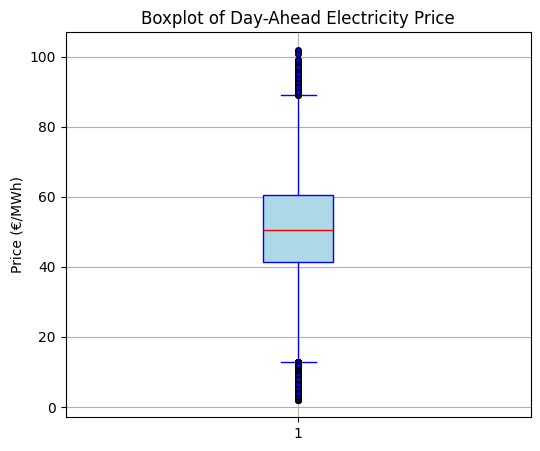

In [75]:
plt.figure(figsize=(6,5))
plt.boxplot(
    energy[target_col],
    vert=True,
    patch_artist=True,
    boxprops=dict(facecolor='lightblue', color='blue'),
    medianprops=dict(color='red'),
    whiskerprops=dict(color='blue'),
    capprops=dict(color='blue'),
    flierprops=dict(marker='o', markersize=4, markerfacecolor='blue')
)
plt.title("Boxplot of Day-Ahead Electricity Price")
plt.ylabel("Price (€/MWh)")
plt.grid(True)
plt.show()


The boxplot shows clear price spikes, confirming the presence of outliers in the target variable. These extreme values reflect real market volatility but may negatively affect several forecasting models. Therefore, while they are kept in the dataset, they will be handled later in paragraph `3.4.3` DOK through appropriate preprocessing to minimise their impact on model performance.

##### 2.4.2.2 Energy features

In [76]:
def boxplots(numeric_features, df):
    num_plots = len(numeric_features)
    cols = 2
    rows = math.ceil(num_plots / cols)

    plt.figure(figsize=(cols * 5, rows * 4))

    for i, feature in enumerate(numeric_features):
        plt.subplot(rows, cols, i + 1)
        sns.boxplot(y=df[feature])
        plt.title(f"Boxplot: {feature}")

    plt.tight_layout()
    plt.show()

def outliers_detection(numericFeatures, df):
    Q1 = df[numericFeatures].quantile(0.25)
    Q3 = df[numericFeatures].quantile(0.75)
    IQR = Q3 - Q1

    outliers = ((df[numericFeatures] < (Q1 - 1.5 * IQR)) | (df[numericFeatures] > (Q3 + 1.5 * IQR)))
    print("Number of outliers per numeric feature:")
    print(outliers.sum())

    outliers_cols = outliers.any()
    outliers_cols = outliers_cols[outliers_cols].index.tolist()
    print("\nColumns containing outliers:")
    print(outliers_cols)


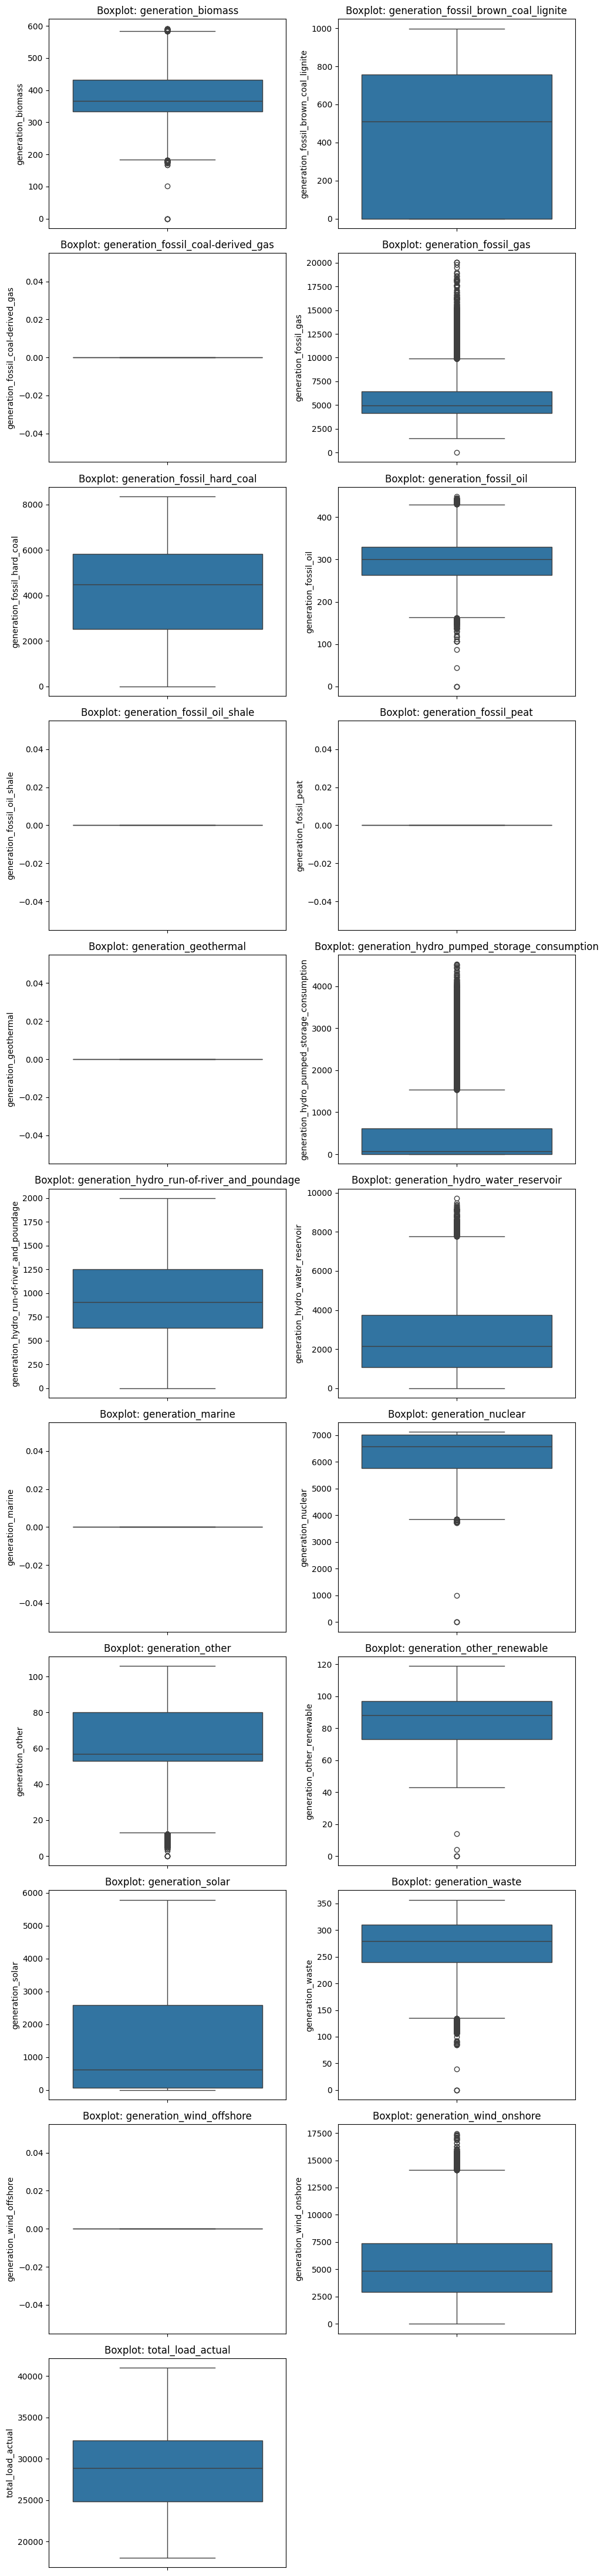

Number of outliers per numeric feature:
generation_biomass                               87
generation_fossil_brown_coal_lignite              0
generation_fossil_coal-derived_gas                0
generation_fossil_gas                          2185
generation_fossil_hard_coal                       0
generation_fossil_oil                           246
generation_fossil_oil_shale                       0
generation_fossil_peat                            0
generation_geothermal                             0
generation_hydro_pumped_storage_consumption    3762
generation_hydro_run-of-river_and_poundage        0
generation_hydro_water_reservoir                343
generation_marine                                 0
generation_nuclear                               74
generation_other                               1267
generation_other_renewable                        5
generation_solar                                  0
generation_waste                                328
generation_wind_offshore

In [77]:
boxplots(energy_features, energy)
outliers_detection(energy_features, energy)

We performed outliers detection on all numerical features using the Interquartile Range (IQR) method and visualized it using boxplots.

Features such as `generation_fossil_gas`, `generation_hydro_pumped_storage_consumption` and `generation_other` contain a high number of outlier values.
`generation_wind_onshore`, `generation_waste`,`generation_hydro_water_reservoir` and `generation_fossil_oil` also contained a noticeable number out outliers.
`generation_biomass` contains a few outliers.
The rest of the features of `energy` dataset showed no outliers according to the IQR method.

##### 2.4.2.3 Weather features

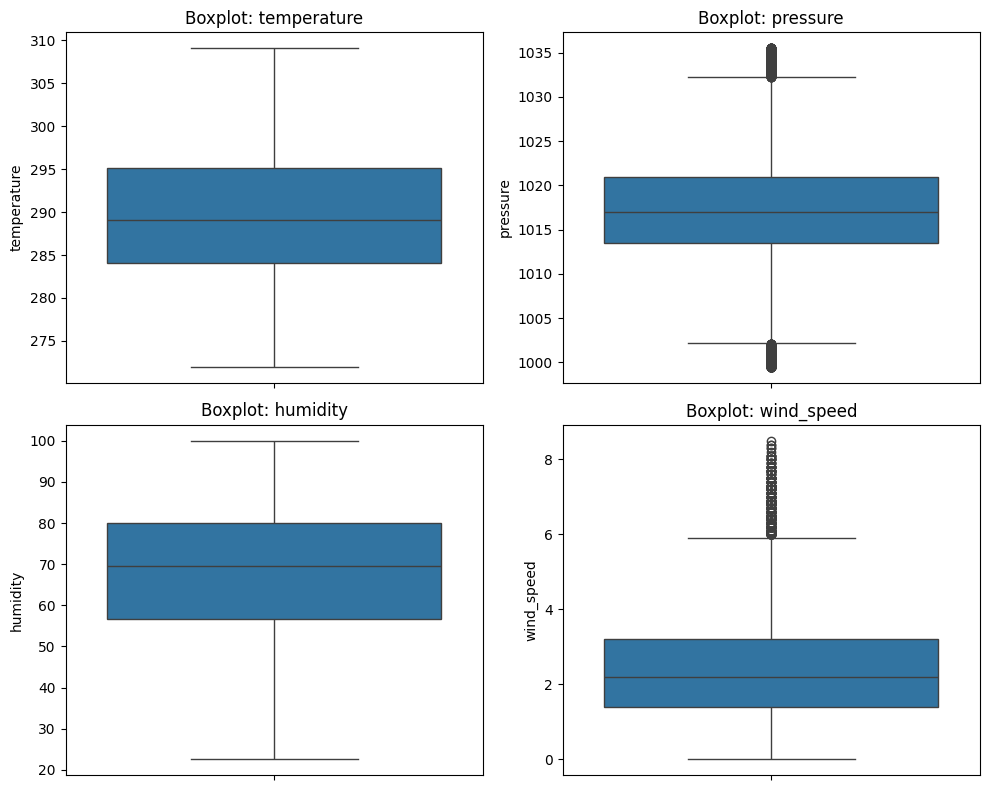

Number of outliers per numeric feature:
temperature      0
pressure       915
humidity         0
wind_speed     600
dtype: int64

Columns containing outliers:
['pressure', 'wind_speed']


In [78]:
boxplots(weather_features, weather)
outliers_detection(weather_features, weather)

`pressure` and `wind_speed` contain a noticeable number of outliers.

In [79]:
outliers_cols = ['pressure', 
                 'wind_speed', 
                 'generation_fossil_gas', 
                 'generation_hydro_pumped_storage_consumption', 
                 'generation_other', 
                 'generation_wind_onshore', 
                 'generation_waste',
                 'generation_hydro_water_reservoir',
                 'generation_biomass',
                 'generation_fossil_oil' ]

#### 2.4.3 Check data duplication

In [80]:
energy.index.duplicated().sum()


np.int64(0)

In [81]:
weather.index.duplicated().sum()

np.int64(0)

There are no duplicates.

---
## 3. Data Preparation

### 3.1 Data Cleaning

#### 3.1.1 Missing values

The first thing to be perfomed is to handle missing values indicated in paragraph `2.4.1`.

The missing values cannot be romoved that's why the NaNs will be filled in and columns only with NaNs will be dropped.

In [82]:
print("Remaining NaNs in energy:", energy.isna().sum().sum())

# Drop columns that contain only NaN values
energy = energy.dropna(axis=1, how='all')

# Interpolate missing values (time-series aware)
energy.index = pd.to_datetime(energy.index, errors='coerce', utc=True)
energy = energy.interpolate(method='time')

# Forward-fill remaining NaNs (edge cases)
energy = energy.ffill().bfill()

print("Remaining NaNs in energy:", energy.isna().sum().sum())


Remaining NaNs in energy: 70529
Remaining NaNs in energy: 0


#### 3.1.2 Handling outliers

To remove outliers identified in paragraph `2.4.2` we will perform winsorization and use **Robust Scaler** during `Data Transformation` in paragraph `3.3`.


### 3.2 Bivariate analysis

Here we will skip features that consist only of values 0.

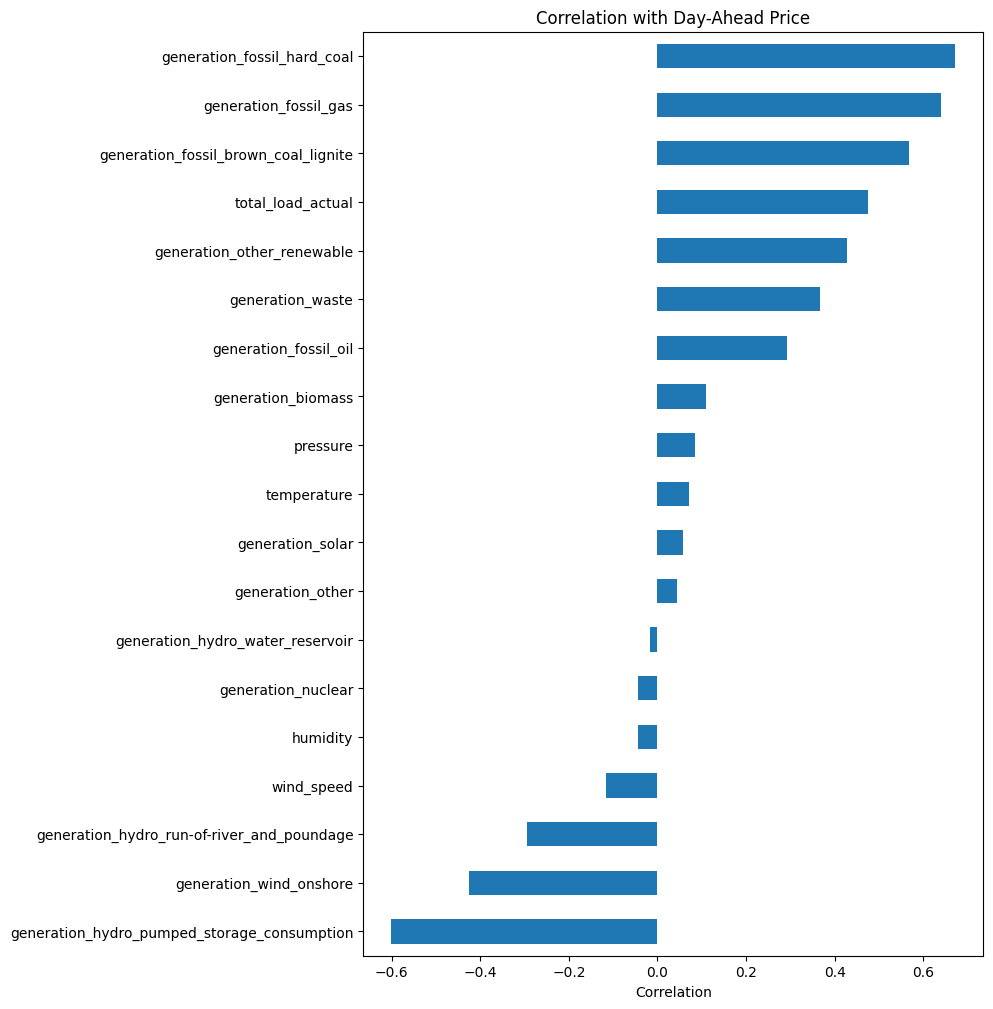

In [83]:
df_analysis = energy.join(weather, how="inner")

# remove columns that are entirely zero
non_zero_cols = df_analysis.columns[(df_analysis != 0).any()]

# keep only numeric features
num_df = df_analysis[non_zero_cols].select_dtypes(include="number")

# compute correlation with price
corr = num_df.corr()[target_col].drop(labels=[target_col]).sort_values()

plt.figure(figsize=(8,12))
corr.plot(kind="barh")
plt.title("Correlation with Day-Ahead Price")
plt.xlabel("Correlation")
plt.show()


The diagram shows that some variables are correlated positively, some nagetively and some are only slightly or not correlated with the target variable at all.

#### Correlation between the eletricity price and the day of the week

time
0    50.897537
1    51.313257
2    51.447382
3    51.178931
4    51.090010
5    47.505215
6    45.702356
Name: price_day_ahead, dtype: float64


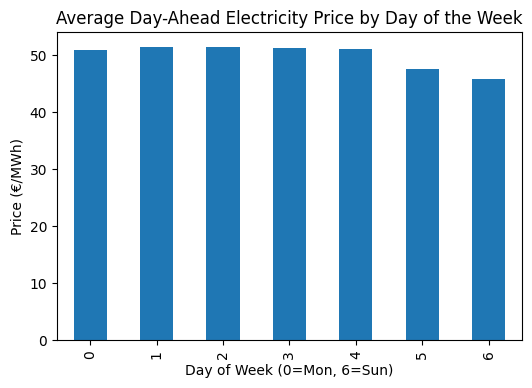

In [84]:
# print(type(energy.index))
# print(energy.index[:5])

weekday_price = energy['price_day_ahead'].groupby(energy.index.to_series().dt.dayofweek).mean()
print(weekday_price)

plt.figure(figsize=(6,4))
weekday_price.plot(kind='bar')
plt.title("Average Day-Ahead Electricity Price by Day of the Week")
plt.ylabel("Price (€/MWh)")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.show()


There's no strong dependency between the day of the week and the eletricity price, however the price tends to be lower on the weekends.

##### Correlation between the temperature and the eletricity price

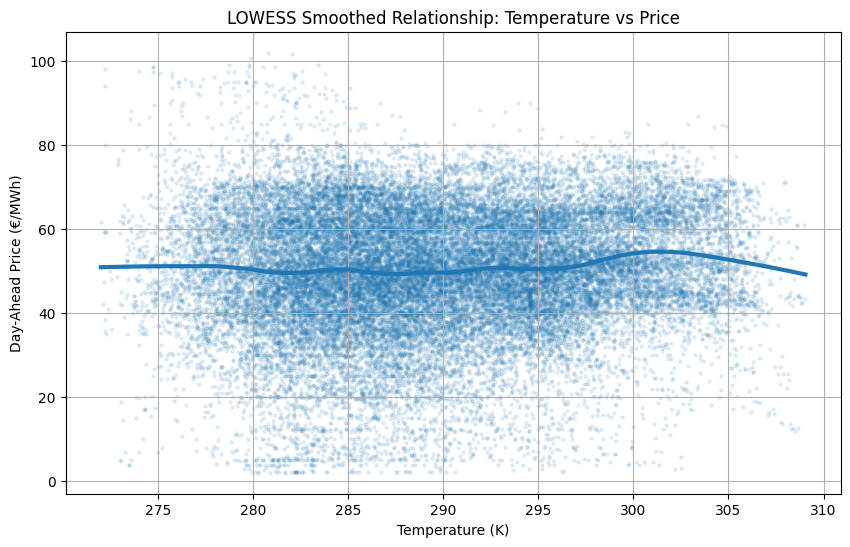

In [85]:
x = df_analysis["temperature"]
y = df_analysis[target_col]

# smooth curve
low = lowess(y, x, frac=0.15)

plt.figure(figsize=(10,6))
plt.scatter(x, y, s=5, alpha=0.1)
plt.plot(low[:,0], low[:,1], linewidth=3)

plt.title("LOWESS Smoothed Relationship: Temperature vs Price")
plt.xlabel("Temperature (K)")
plt.ylabel("Day-Ahead Price (€/MWh)")
plt.grid(True)
plt.show()


There's no significant correlation between the eletricity price and the temperature.

### 3.3 Data Transformation

Since all the features are numerical they don't have to be encoded in any way.

#### 3.3.1 Dropping unnecessary variables

There are variables with all 0 values. They will be dropped.

In [86]:
df = energy.join(weather, how="inner")

dfML = df.copy()

zero_cols = dfML.columns[(dfML == 0).all()]
print("Dropped columns with all zeros:", list(zero_cols))

dfML = dfML.drop(columns=zero_cols)

dfML.info()

Dropped columns with all zeros: ['generation_fossil_coal-derived_gas', 'generation_fossil_oil_shale', 'generation_fossil_peat', 'generation_geothermal', 'generation_marine', 'generation_wind_offshore']
<class 'pandas.core.frame.DataFrame'>
Index: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 20 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation_biomass                           35064 non-null  float64
 1   generation_fossil_brown_coal_lignite         35064 non-null  float64
 2   generation_fossil_gas                        35064 non-null  float64
 3   generation_fossil_hard_coal                  35064 non-null  float64
 4   generation_fossil_oil                        35064 non-null  float64
 5   generation_hydro_pumped_storage_consumption  35064 non-null  float64
 6   generation_hydro_run-of-river_and_poundage   35064 no


#### 3.3.1 Handling variables with skewed distribution

Since not all of the skewed distrubutions concern variables with positive values we will use **Yeo-Johnson** scaler.

In [87]:
# Cast to float before transformation to avoid dtype issues
dfML = dfML.copy()

for col in skewed_cols:
    dfML[col] = dfML[col].astype(float)

In [88]:
pt = PowerTransformer(method='yeo-johnson')

print(df[skewed_cols].dtypes)

dfML.loc[:, skewed_cols] = pt.fit_transform(dfML.loc[:, skewed_cols])

generation_hydro_pumped_storage_consumption    float64
generation_hydro_water_reservoir               float64
generation_solar                               float64
generation_wind_onshore                        float64
generation_waste                               float64
wind_speed                                     float64
dtype: object


#### 3.3.2 Handling outliers

As indicated in paragraph `3.1`, we will use **Robust Scaler** to handle outliers.

In [89]:
# Feature scaling

# Initialize the scaler
scaler = RobustScaler()

print(outliers_cols)
print(type(outliers_cols))

# Fit the scaler on the numeric features and transform
dfML.loc[:,outliers_cols] = scaler.fit_transform(dfML[outliers_cols])

['pressure', 'wind_speed', 'generation_fossil_gas', 'generation_hydro_pumped_storage_consumption', 'generation_other', 'generation_wind_onshore', 'generation_waste', 'generation_hydro_water_reservoir', 'generation_biomass', 'generation_fossil_oil']
<class 'list'>


### 3.4 Data Splitting

To evaluate the models used in paragraph `4` we have to split dataset into a train and a test set. We will use an 75/25 split ratio (the whole dataset represents 4 years of data and the test set will consist of last 12 months) to ensure sufficient amount of data for training while retaining enough samples for meaningful evaluation.

In [90]:
# Last 12 months for test
split_date = dfML.index.max() - pd.DateOffset(years=1)

train_dfML = dfML[dfML.index <= split_date]
test_dfML  = dfML[dfML.index > split_date]

print("Split date:", split_date)
print("Train:", train_dfML.shape)
print("Test:", test_dfML.shape)

Split date: 2017-12-31 22:00:00+00:00
Train: (26304, 20)
Test: (8760, 20)


### 3.5 Feature selection

#### Embedded method - Lasso regularization

In [91]:
def lasso_regularization(df, target_col="price_day_ahead"):

    X = df.drop(columns=[target_col]).copy()
    y = df[target_col].copy()

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    lasso = Lasso(alpha=0.01, random_state=42, max_iter=5000)

    sel_ = SelectFromModel(lasso)
    sel_.fit(X_scaled, y)

    selected_feat = X.columns[sel_.get_support()]
    removed_feat = X.columns[~sel_.get_support()]

    print(f"Selected features ({len(selected_feat)}):")
    print(selected_feat.tolist())

    print(f"\nRemoved features ({len(removed_feat)}):")
    print(removed_feat.tolist())

    return selected_feat

In [92]:
Lasso_SelectedColumns = lasso_regularization(train_dfML)

Lasso_SelectedColumns

Selected features (19):
['generation_biomass', 'generation_fossil_brown_coal_lignite', 'generation_fossil_gas', 'generation_fossil_hard_coal', 'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption', 'generation_hydro_run-of-river_and_poundage', 'generation_hydro_water_reservoir', 'generation_nuclear', 'generation_other', 'generation_other_renewable', 'generation_solar', 'generation_waste', 'generation_wind_onshore', 'total_load_actual', 'temperature', 'pressure', 'humidity', 'wind_speed']

Removed features (0):
[]


Index(['generation_biomass', 'generation_fossil_brown_coal_lignite',
       'generation_fossil_gas', 'generation_fossil_hard_coal',
       'generation_fossil_oil', 'generation_hydro_pumped_storage_consumption',
       'generation_hydro_run-of-river_and_poundage',
       'generation_hydro_water_reservoir', 'generation_nuclear',
       'generation_other', 'generation_other_renewable', 'generation_solar',
       'generation_waste', 'generation_wind_onshore', 'total_load_actual',
       'temperature', 'pressure', 'humidity', 'wind_speed'],
      dtype='object')

In [93]:
train_dfML = train_dfML[list(Lasso_SelectedColumns) + [target_col]]
test_dfML  = test_dfML[list(Lasso_SelectedColumns) + [target_col]]

TODO

With these methods, we prepared a dataframes for future testing and tuning to compare different models and select the one with the best performance.

---
## 4. Modelling

### 4.1 Statistical Models

#### 4.1.1 Subset selection

In [94]:
test_dfML.index = pd.to_datetime(test_dfML.index)
train_dfML.index = pd.to_datetime(train_dfML.index)
type(train_dfML.index)


pandas.core.indexes.datetimes.DatetimeIndex

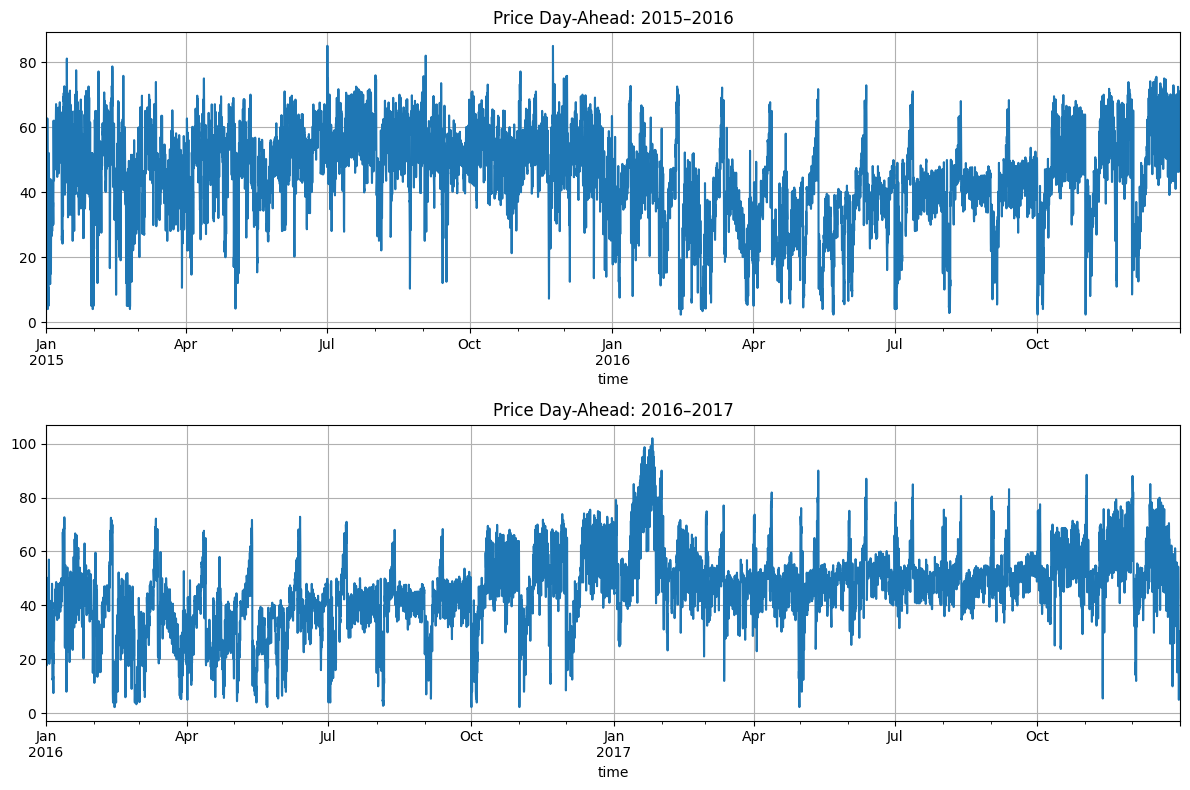

In [95]:
periods = [
    ('2015-01-01', '2016-12-31'),
    ('2016-01-01', '2017-12-31')
]

plt.figure(figsize=(12, 8))

for i, (start, end) in enumerate(periods, 1):
    plt.subplot(2, 1, i)
    train_dfML.loc[start:end, 'price_day_ahead'].plot()
    plt.title(f'Price Day-Ahead: {start[:4]}–{end[:4]}')
    plt.grid(True)

plt.tight_layout()
plt.show()

In [96]:
train_stat= train_dfML.loc[start:end, :]
train_stat

,generation_biomass,generation_fossil_brown_coal_lignite,generation_fossil_gas,generation_fossil_hard_coal,generation_fossil_oil,generation_hydro_pumped_storage_consumption,generation_hydro_run-of-river_and_poundage,generation_hydro_water_reservoir,generation_nuclear,generation_other,generation_other_renewable,generation_solar,generation_waste,generation_wind_onshore,total_load_actual,temperature,pressure,humidity,wind_speed,price_day_ahead
time,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00+00:00,0.37,0.0,-0.232523,1866.0,-1.253731,0.352251,682.0,-0.129482,7080.0,0.555556,77.0,-1.472075,-1.338930,-0.383372,21632.0,283.1500,1.063123,92.6,-0.532033,40.00
2016-01-01 01:00:00+00:00,0.28,0.0,-0.296787,1422.0,-1.417910,0.439950,660.0,-0.365852,7079.0,0.703704,78.0,-1.472075,-1.335463,-0.282144,20357.0,282.3274,0.930233,91.0,-0.242058,33.10
2016-01-01 02:00:00+00:00,0.24,0.0,-0.502171,1146.0,-1.462687,0.528612,651.0,-0.636676,7080.0,0.888889,71.0,-1.472075,-1.335463,-0.122663,19152.0,282.9100,0.930233,91.0,-0.380029,28.11
2016-01-01 03:00:00+00:00,0.17,0.0,-0.476552,1081.0,-1.492537,0.590467,626.0,-0.949616,7078.0,1.111111,71.0,-1.472075,-1.345717,0.058058,18310.0,283.0510,0.877076,90.6,-0.242058,27.13
2016-01-01 04:00:00+00:00,0.14,0.0,-0.416630,1108.0,-1.298507,0.615448,616.0,-1.062632,7080.0,1.148148,71.0,-1.472075,-1.338930,0.183655,18054.0,283.1920,0.850498,90.6,-0.242058,25.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 18:00:00+00:00,-0.94,0.0,-0.811333,806.0,-1.522388,0.235024,1119.0,-0.113076,7093.0,-0.111111,79.0,-1.733532,-0.502740,1.499546,29097.0,286.3640,0.558140,68.6,0.928659,30.43
2017-12-31 19:00:00+00:00,-1.00,0.0,-0.845636,764.0,-1.552239,0.375805,1115.0,-0.089960,7095.0,-0.111111,80.0,-1.733532,-0.525070,1.443126,28666.0,286.1780,0.717608,65.6,1.131181,30.01
2017-12-31 20:00:00+00:00,-0.99,0.0,-0.766175,784.0,-1.731343,0.447544,1121.0,-0.337775,7096.0,-0.111111,79.0,-1.733532,-0.502740,1.429964,27260.0,285.9460,0.823920,66.6,0.813224,22.01


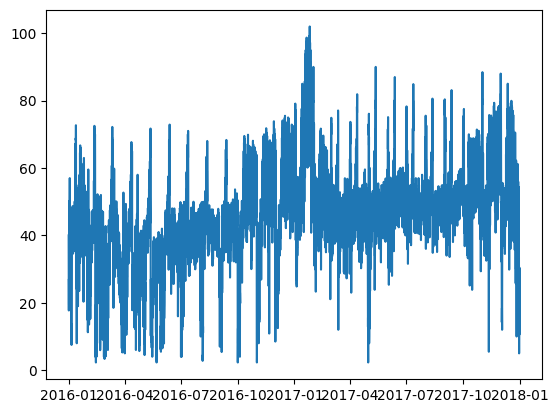

In [97]:
plt.plot(train_stat['price_day_ahead'])
plt.show()

##### Decomposition

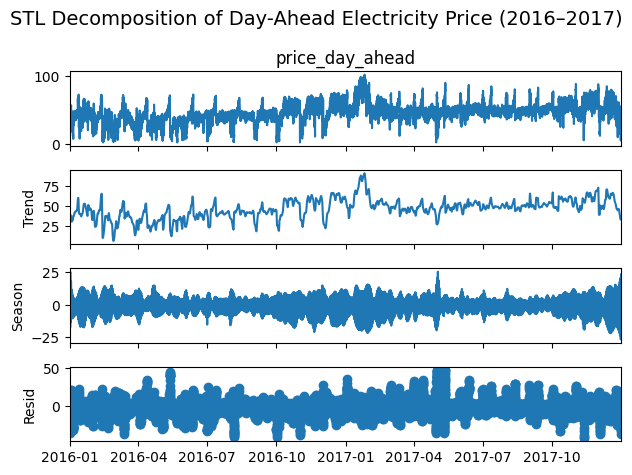

In [98]:
stl = STL(train_stat['price_day_ahead'], period=24, robust=True)
res = stl.fit()

fig = res.plot()
fig.suptitle(
    'STL Decomposition of Day-Ahead Electricity Price (2016–2017)',
    fontsize=14
)
plt.tight_layout()
plt.show()

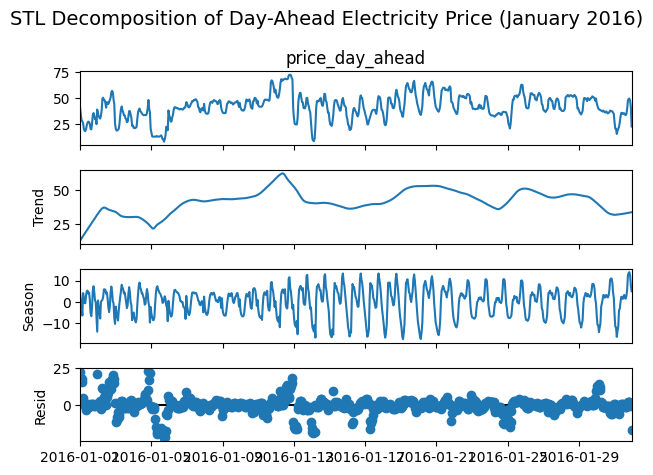

In [99]:
short_series = train_stat['price_day_ahead'].loc['2016-01-01':'2016-01-31']

stl_short = STL(short_series, period=24, robust=True)
res_short = stl_short.fit()

fig = res_short.plot()
fig.suptitle(
    'STL Decomposition of Day-Ahead Electricity Price (January 2016)',
    fontsize=14
)
plt.tight_layout()
plt.show()


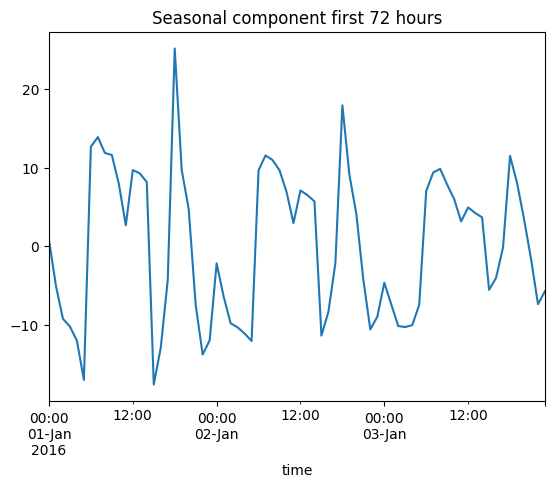

In [100]:
res.seasonal.iloc[:72].plot(
    title='Seasonal component first 72 hours'
)
plt.show()

#### 4.1.2 Stationarity testing (ADF)

In [101]:
def adf_test(series):
    results = adfuller(series)
    print(f"ADF statistic: {results[0]}")
    print(f"p-value: {results[1]}")
    print('Critical values: ')
    for thres, adf_stat in results[4].items():
        print(thres, adf_stat)

In [102]:
adf_test(train_stat['price_day_ahead'])

ADF statistic: -7.417359014094735
p-value: 6.879191292024519e-11
Critical values: 
1% -3.430723771835013
5% -2.8617051927135266
10% -2.5668579277936123


In [103]:
def rolling_mean_sd(series):
    rolling_mean = series.rolling(window=168).mean()
    rolling_std = series.rolling(window=168).std()

    fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

    axes[0].plot(series, alpha=0.25, label='Original')
    axes[0].plot(rolling_mean, color='orange', linewidth=2, label='Rolling Mean (7 days)')
    axes[0].set_title('Rolling Mean (7 days Window)')
    axes[0].legend()
    axes[1].plot(rolling_std, color='green', linewidth=2, label='Rolling Std (7 days)')
    axes[1].set_title('Rolling Standard Deviation (7 days Window)')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

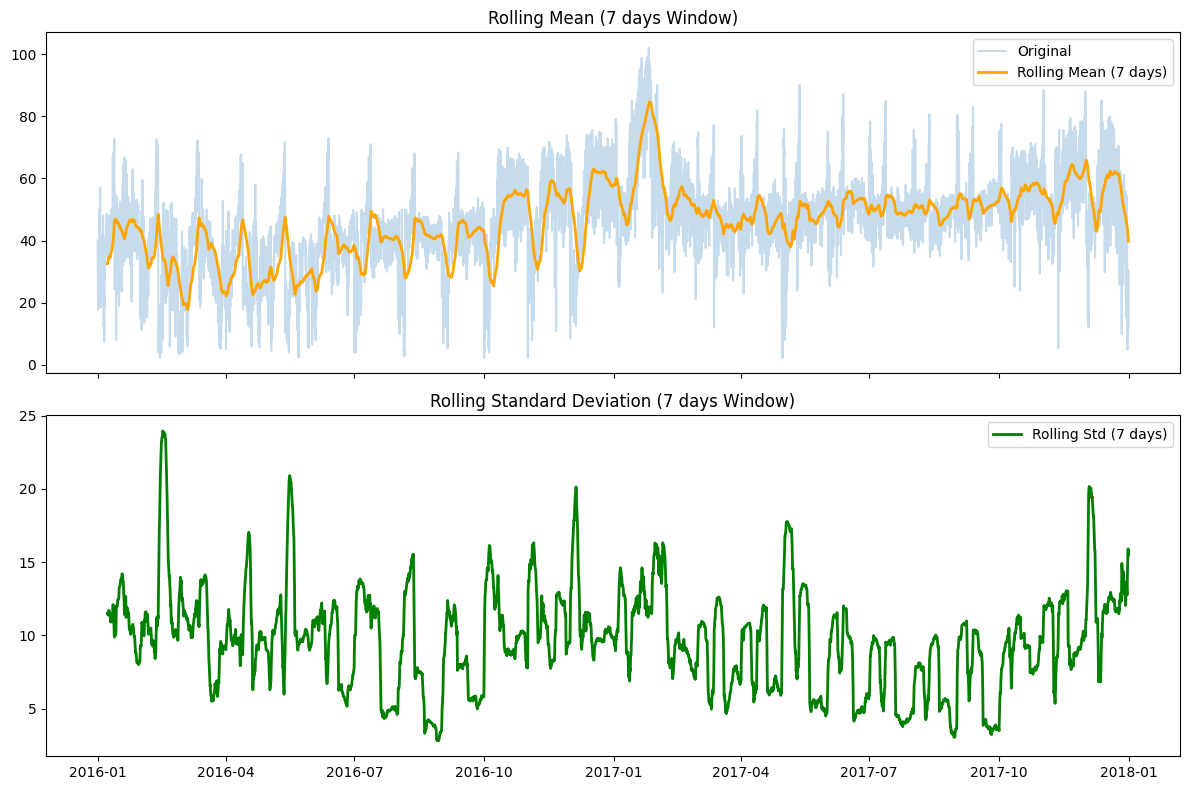

In [104]:
rolling_mean_sd(train_stat['price_day_ahead'])

In [105]:
train_seas_diff = train_stat['price_day_ahead'].diff(24).dropna()

In [106]:
adf_test(train_seas_diff)

ADF statistic: -24.210066973471033
p-value: 0.0
Critical values: 
1% -3.4307242852745428
5% -2.8617054196196627
10% -2.566858048572343


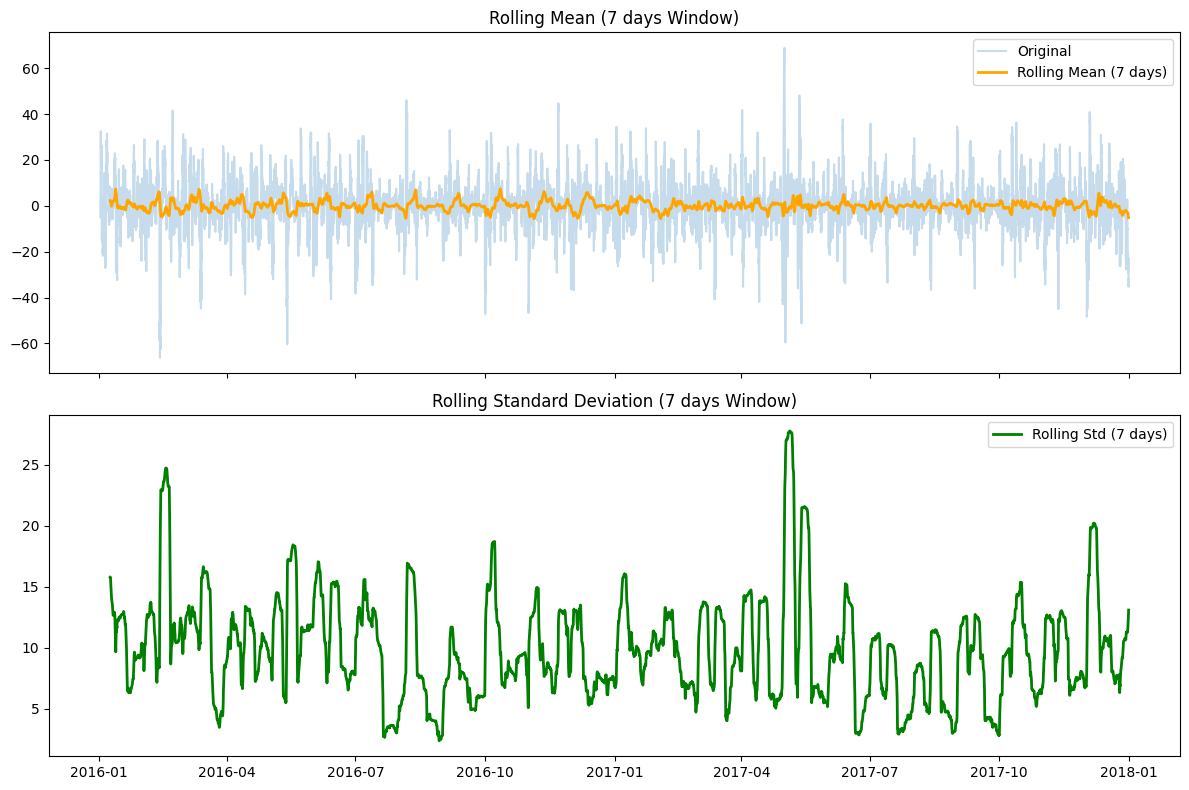

In [107]:
rolling_mean_sd(train_seas_diff)

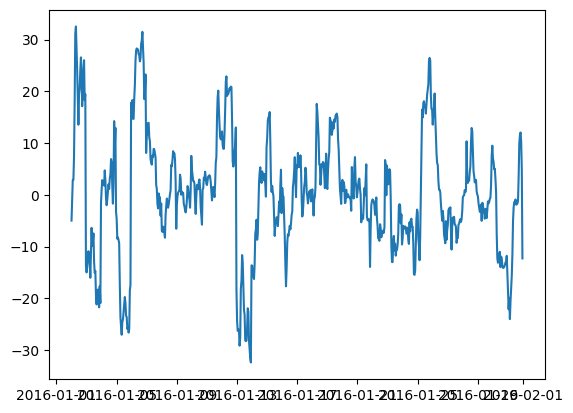

In [108]:
plt.plot(train_seas_diff.loc['2016-01-01':'2016-01-31'])

#### 4.1.3 ACF/PACF analysis

<Figure size 800x400 with 0 Axes>

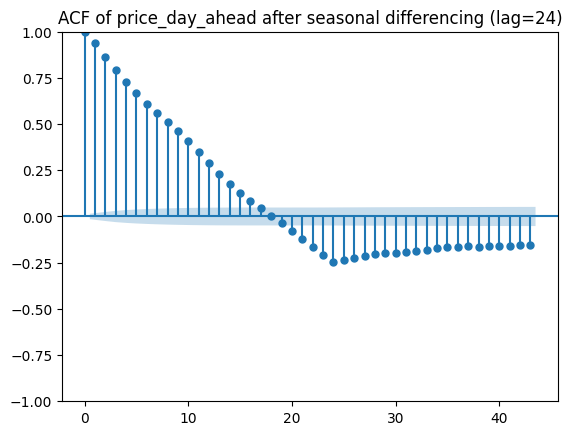

In [109]:
plt.figure(figsize=(8,4))
plot_acf(train_seas_diff)
plt.title('ACF of price_day_ahead after seasonal differencing (lag=24)')
plt.show()

<Figure size 1000x400 with 0 Axes>

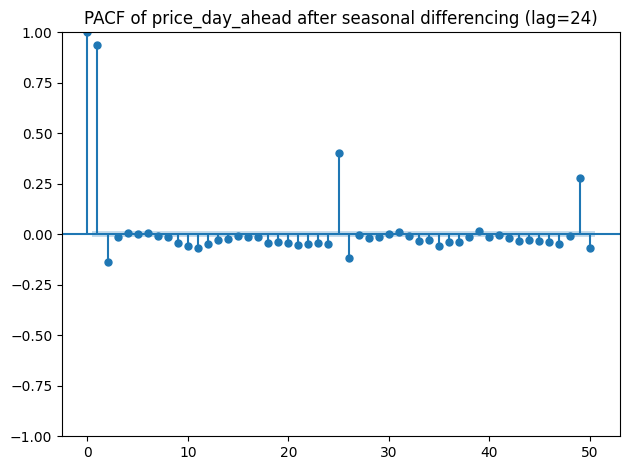

In [110]:
plt.figure(figsize=(10, 4))
plot_pacf(
    train_seas_diff,
    lags=50,
    method='ywm' 
)
plt.title('PACF of price_day_ahead after seasonal differencing (lag=24)')
plt.tight_layout()
plt.show()

#### 4.1.4 SARIMA

SARIMA(1,0,0)(1,1,0,24)

c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


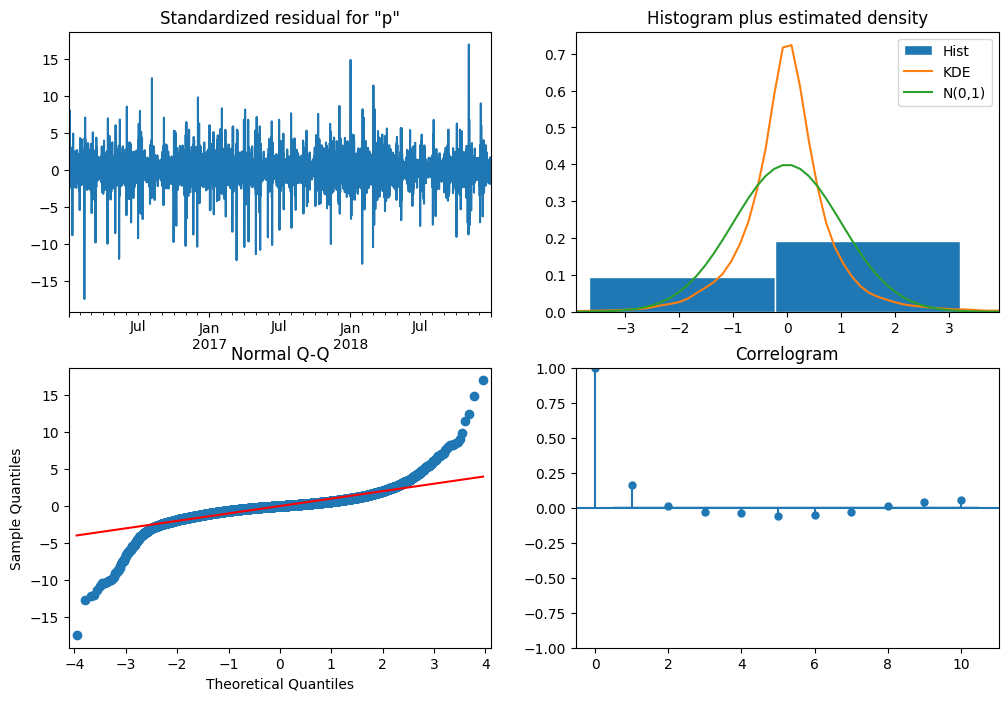

                                     SARIMAX Results                                      
Dep. Variable:                    price_day_ahead   No. Observations:                26303
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 24)   Log Likelihood              -69783.669
Date:                            Sat, 20 Dec 2025   AIC                         139573.337
Time:                                    03:14:48   BIC                         139597.864
Sample:                                01-01-2016   HQIC                        139581.257
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9487      0.002    585.534      0.000       0.946       0.952
ar.S.L24      -0.4288      0.002   

In [114]:
y_train = train_stat['price_day_ahead']
y_test  = test_dfML['price_day_ahead']
y_all = pd.concat([y_train, y_test])

sarima_model = SARIMAX(
    y_train,
    order=(1,0,0),
    seasonal_order=(1,1,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_res_train = sarima_model.fit()

sarima_model_all = SARIMAX(
    y_all,
    order=(1,0,0),
    seasonal_order=(1,1,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_res_all = sarima_model_all.filter(sarima_res_train.params)

sarima_res_all.plot_diagnostics(figsize=(12, 8))
plt.show()
print(sarima_res_all.summary())

#### 4.1.5 SARIMAX using relevant exogenous variables


In [203]:
y_train = train_stat['price_day_ahead']
y_test  = test_dfML['price_day_ahead']
exog_cols = [
    'total_load_actual',
    'generation_wind_onshore',
    'generation_fossil_gas'
]
X_train = train_stat[exog_cols]
X_test = test_dfML[exog_cols]

print(y_train.isna().sum())
print(X_train.isna().sum())


0
total_load_actual          0
generation_wind_onshore    0
generation_fossil_gas      0
dtype: int64


c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\epaw0\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\Users\epaw0\AppData\Local\Programs\Py

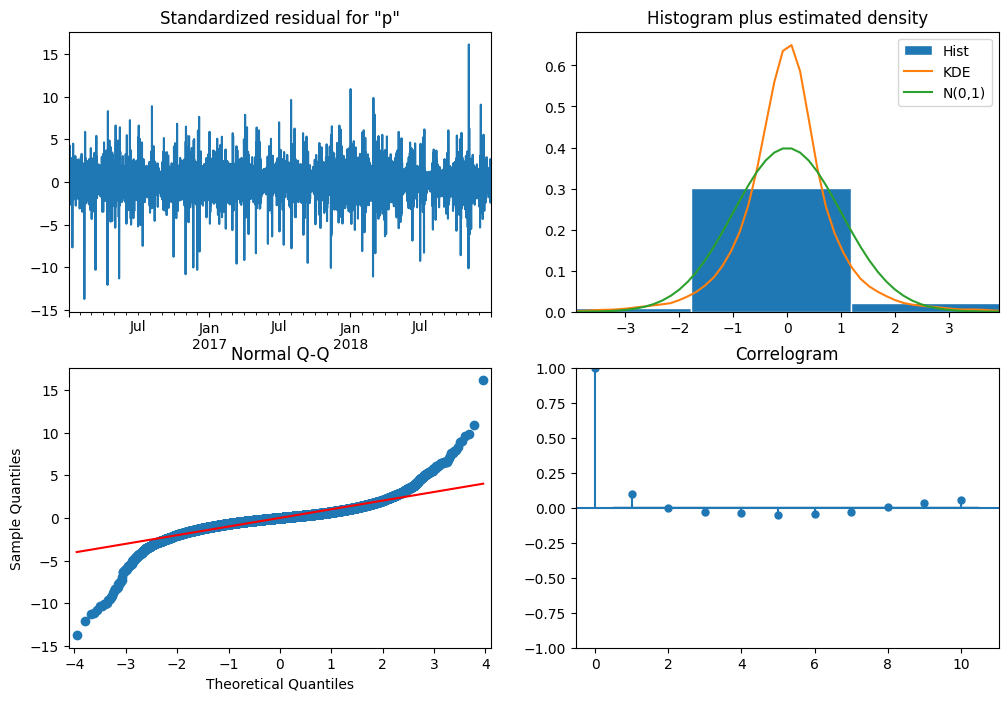

                                     SARIMAX Results                                      
Dep. Variable:                    price_day_ahead   No. Observations:                26303
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 24)   Log Likelihood              -65530.865
Date:                            Sat, 20 Dec 2025   AIC                         131073.730
Time:                                    04:22:39   BIC                         131122.784
Sample:                                01-01-2016   HQIC                        131089.570
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
total_load_actual           0.0015   1.05e-05    140.891      0.000       0.001       0.

In [204]:
y_all = pd.concat([y_train, y_test])
X_all = pd.concat([X_train, X_test])

sarimax_model = SARIMAX(
    y_train,
    exog=X_train,
    order=(1,0,0),
    seasonal_order=(1,1,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_res_train = sarimax_model.fit()

sarimax_model_all = SARIMAX(
    y_all,
    exog=X_all,
    order=(1,0,0),
    seasonal_order=(1,1,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_res_all = sarimax_model_all.filter(sarimax_res_train.params)

sarimax_res_all.plot_diagnostics(figsize=(12, 8))
plt.show()
print(sarimax_res_all.summary())

#### 4.1.6 Residual diagnostics

In [126]:
residuals_sarima = sarima_res_all.resid
df_residuals = train_stat.copy()
df_residuals['residuals'] = residuals_sarima
df_residuals['fittedvales'] = sarima_res_all.fittedvalues
df_residuals[['price_day_ahead','fittedvales','residuals']]

,price_day_ahead,fittedvales,residuals
time,,,
2016-01-01 00:00:00+00:00,40.00,0.000000,40.000000
2016-01-01 01:00:00+00:00,33.10,18.974852,14.125148
2016-01-01 02:00:00+00:00,28.11,25.933683,2.176317
2016-01-01 03:00:00+00:00,27.13,25.853925,1.276075
2016-01-01 04:00:00+00:00,25.24,25.263633,-0.023633
...,...,...,...
2017-12-31 18:00:00+00:00,30.43,28.697536,1.732464
2017-12-31 19:00:00+00:00,30.01,30.538159,-0.528159
2017-12-31 20:00:00+00:00,22.01,29.625981,-7.615981


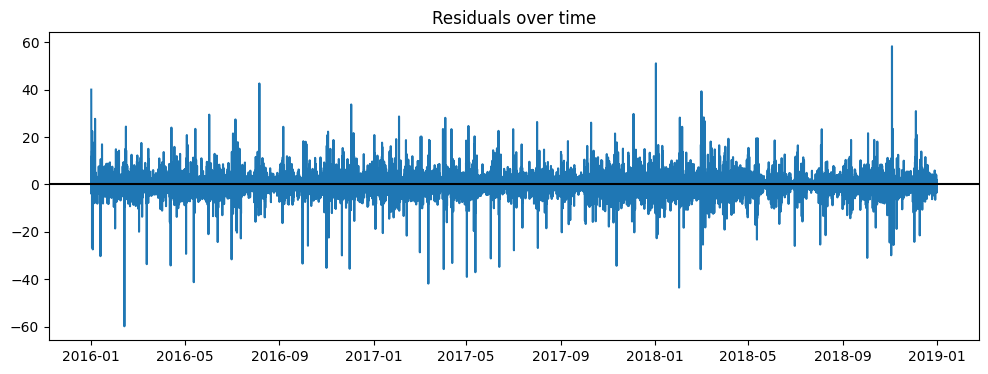

In [127]:
plt.figure(figsize=(12,4))
plt.plot(residuals_sarima)
plt.axhline(0, color='black')
plt.title("Residuals over time")
plt.show()

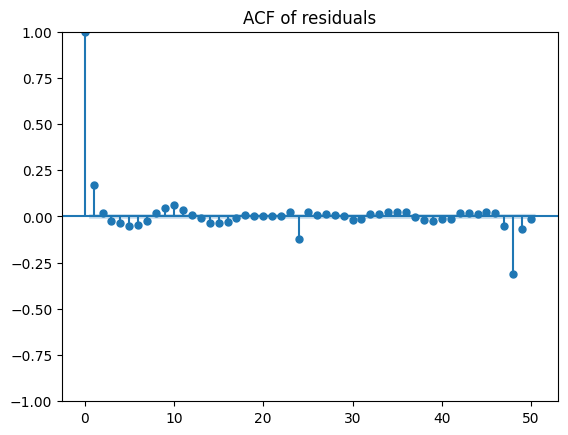

In [128]:
plot_acf(residuals_sarima, lags=50)
plt.title("ACF of residuals")
plt.show()

<Figure size 1000x400 with 0 Axes>

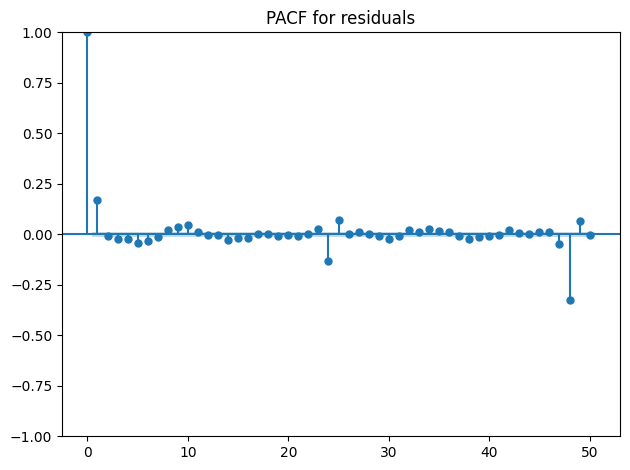

In [129]:
plt.figure(figsize=(10, 4))
plot_pacf(
    residuals_sarima,
    lags=50,
    method='ywm' 
)
plt.title('PACF for residuals')
plt.tight_layout()
plt.show()

In [130]:
lb_test = acorr_ljungbox(residuals_sarima, lags=[24], return_df=True)
print(lb_test)

        lb_stat  lb_pvalue
24  1665.502722        0.0


##### SARIMAX exogenous variables

In [131]:
residuals = sarimax_res_all.resid
df_residuals = train_stat.copy()
df_residuals['residuals'] = residuals
df_residuals['fittedvales'] = sarimax_res_all.fittedvalues
df_residuals[['price_day_ahead','fittedvales','residuals']]

,price_day_ahead,fittedvales,residuals
time,,,
2016-01-01 00:00:00+00:00,40.00,0.000000,40.000000
2016-01-01 01:00:00+00:00,33.10,18.974852,14.125148
2016-01-01 02:00:00+00:00,28.11,25.933683,2.176317
2016-01-01 03:00:00+00:00,27.13,25.853925,1.276075
2016-01-01 04:00:00+00:00,25.24,25.263633,-0.023633
...,...,...,...
2017-12-31 18:00:00+00:00,30.43,28.697536,1.732464
2017-12-31 19:00:00+00:00,30.01,30.538159,-0.528159
2017-12-31 20:00:00+00:00,22.01,29.625981,-7.615981


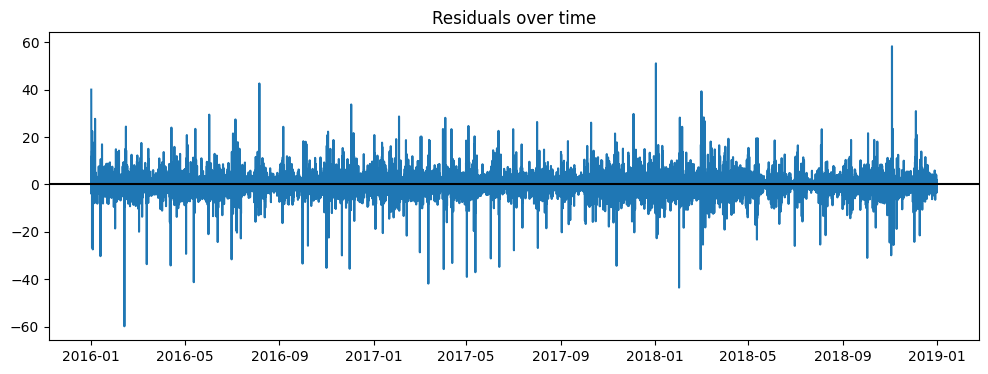

In [132]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.axhline(0, color='black')
plt.title("Residuals over time")
plt.show()

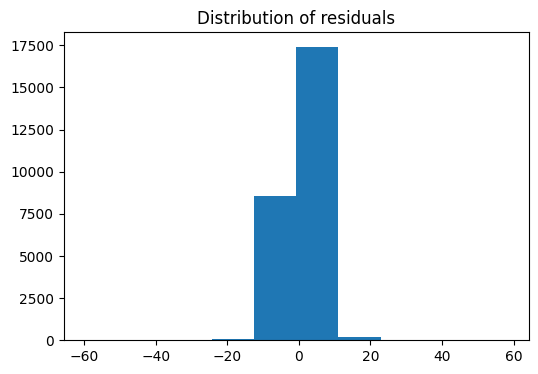

In [133]:
plt.figure(figsize=(6,4))
plt.hist(residuals)
plt.title("Distribution of residuals")
plt.show()

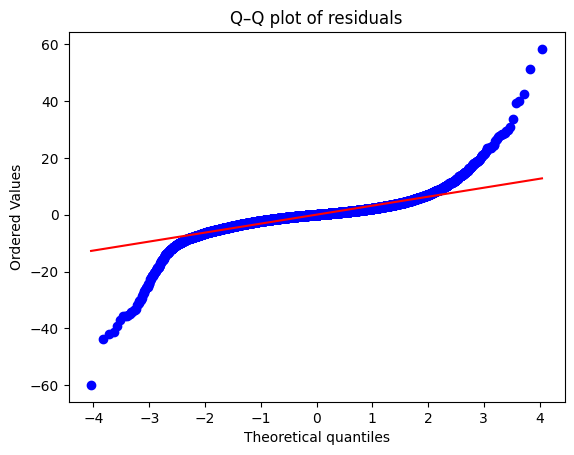

In [134]:
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q–Q plot of residuals")
plt.show()

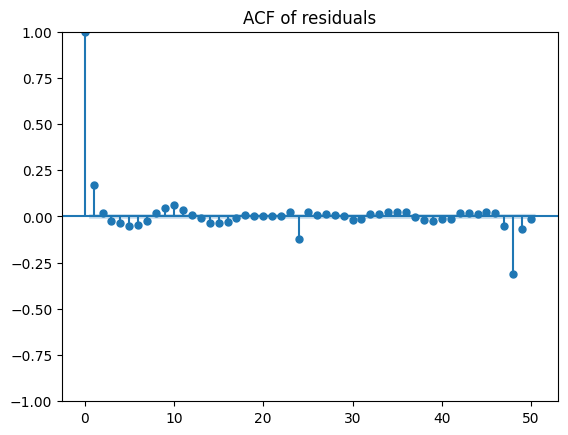

In [135]:
plot_acf(residuals, lags=50)
plt.title("ACF of residuals")
plt.show()

<Figure size 1000x400 with 0 Axes>

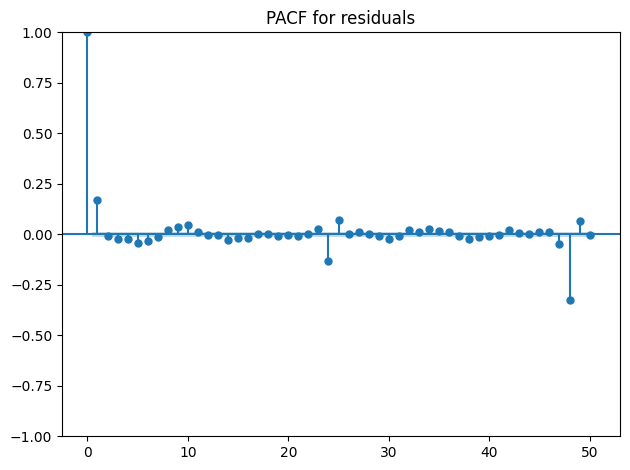

In [136]:
plt.figure(figsize=(10, 4))
plot_pacf(
    residuals,
    lags=50,
    method='ywm' 
)
plt.title('PACF for residuals')
plt.tight_layout()
plt.show()

In [137]:
lb_test = acorr_ljungbox(residuals, lags=[24], return_df=True)
print(lb_test)

        lb_stat  lb_pvalue
24  1665.502722        0.0


#### 4.1.7 Forecast 1-step ahead and 24-step ahead

In [205]:
y_test  = test_dfML['price_day_ahead']
y_test  = y_test.asfreq('H')

C:\Users\epaw0\AppData\Local\Temp\ipykernel_44216\3704658872.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  y_test  = y_test.asfreq('H')


##### 1-step ahead forecast

In [206]:
pred_sarima = sarima_res_all.get_prediction(
    start=y_test.index[0],
    end=y_test.index[-1],
    dynamic=False
)

y_hat_sarima = pred_sarima.predicted_mean

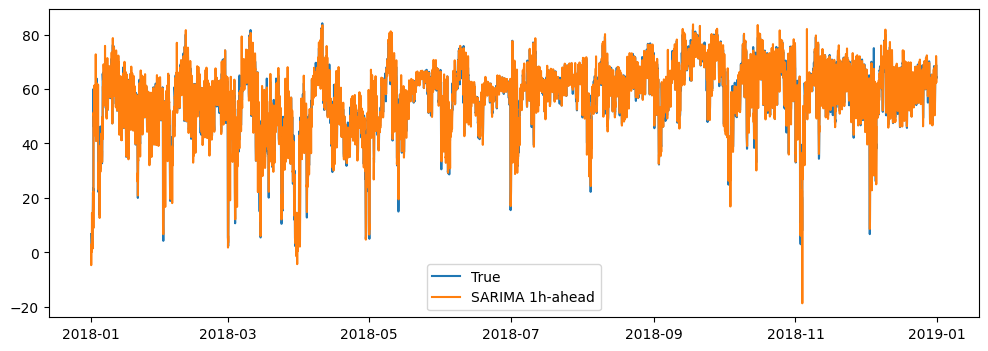

In [207]:
plt.figure(figsize=(12,4))
plt.plot(y_test, label="True")
plt.plot(y_hat_sarima, label="SARIMA 1h-ahead")
plt.legend()
plt.show()

In [208]:
pred_sarimax = sarimax_res_all.get_prediction(
    start=y_test.index[0],
    end=y_test.index[-1],
    exog=X_test,
    dynamic=False
)

y_hat_sarimax = pred_sarimax.predicted_mean

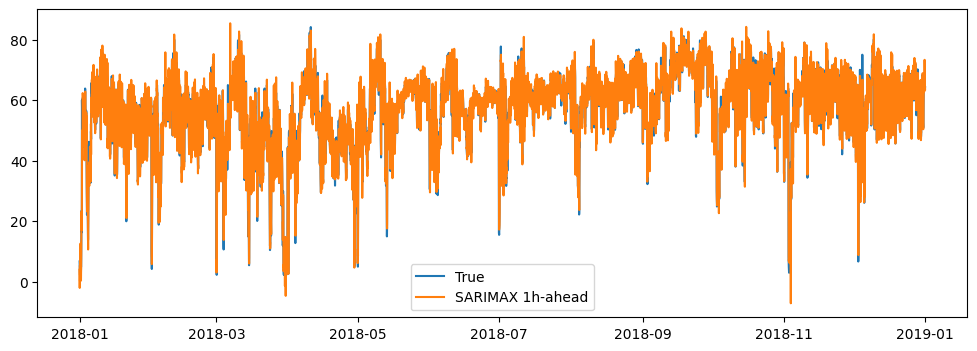

In [209]:
plt.figure(figsize=(12,4))
plt.plot(y_test, label="True")
plt.plot(y_hat_sarimax, label="SARIMAX 1h-ahead")
plt.legend()
plt.show()

##### 24-steps ahead

In [210]:
sarima_predictions_list = []

for i in range(0, len(y_test), 24):
    start_point = y_test.index[i]
    
    pred = sarima_res_all.get_prediction(
        start=start_point,
        end=start_point + pd.Timedelta(hours=23),
        exog=X_test,
        dynamic=start_point
    )
    
    sarima_predictions_list.append(pred.predicted_mean)

y_hat_24h_sarima = pd.concat(sarima_predictions_list)


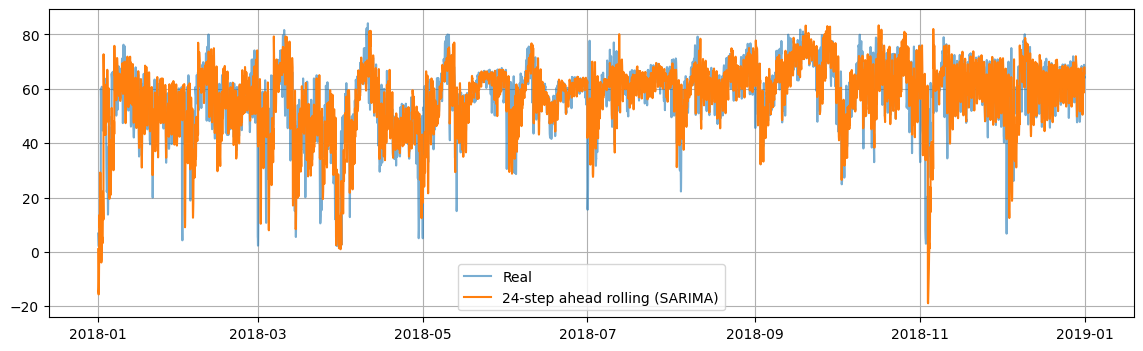

In [211]:
plt.figure(figsize=(14,4))
plt.plot(y_test, label="Real", alpha=0.6)
plt.plot(y_hat_24h_sarima, label="24-step ahead rolling (SARIMA)")
plt.legend()
plt.grid(True)
plt.show()

In [212]:
sarimax_predictions_list = []

for i in range(0, len(y_test), 24):
    start_point = y_test.index[i]

    exog_block = X_test.loc[start_point : start_point + pd.Timedelta(hours=23)]

    pred = sarimax_res_all.get_prediction(
        start=start_point,
        end=start_point + pd.Timedelta(hours=23),
        exog=exog_block,
        dynamic=start_point
    )

    sarimax_predictions_list.append(pred.predicted_mean)

y_hat_24h_sarimax = pd.concat(sarimax_predictions_list)


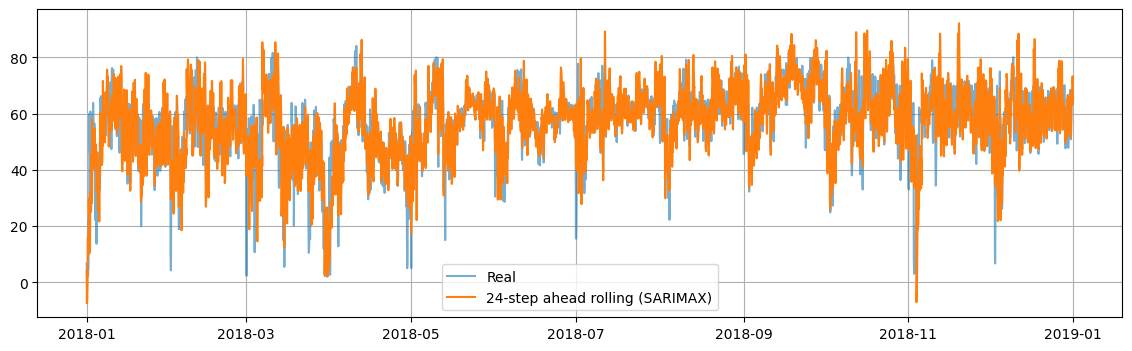

In [213]:
plt.figure(figsize=(14,4))
plt.plot(y_test, label="Real", alpha=0.6)
plt.plot(y_hat_24h_sarimax, label="24-step ahead rolling (SARIMAX)")
plt.legend()
plt.grid(True)
plt.show()

#### 4.1.8 Evaluation metrcis and comparision

In [214]:
def compute_metrics(y_true, y_pred):
    idx = y_true.index.intersection(y_pred.index)
    y_t = y_true.loc[idx]
    y_p = y_pred.loc[idx]

    mae = np.mean(np.abs(y_t - y_p))
    rmse = np.sqrt(np.mean((y_t - y_p) ** 2))
    mape = np.mean(
        np.abs((y_t - y_p) / y_t.replace(0, np.nan))
    ) * 100

    return mae, rmse, mape

In [215]:
results = []
results.append(('SARIMA', '1-step', *compute_metrics(y_test, y_hat_sarima)))
results.append(('SARIMAX', '1-step', *compute_metrics(y_test, y_hat_sarimax)))
results.append(('SARIMA', '24-step', *compute_metrics(y_test, y_hat_24h_sarima)))
results.append(('SARIMAX', '24-step',*compute_metrics(y_test, y_hat_24h_sarimax)))
df_stat_results = pd.DataFrame(results, columns=['Model', 'step', 'MAE', 'RMSE', 'MAPE'])
df_stat_results


,Model,step,MAE,RMSE,MAPE
0,SARIMA,1-step,2.096742,3.488218,5.020176
1,SARIMAX,1-step,1.891775,3.006883,4.520461
2,SARIMA,24-step,6.261477,9.451988,18.116268
3,SARIMAX,24-step,5.143137,7.328757,14.496339


In [216]:
print("SARIMA AIC :", sarima_res_train.aic)
print("SARIMAX AIC:", sarimax_res_train.aic)

SARIMA AIC : 92819.89751124922
SARIMAX AIC: 86902.82711070757


### 4.2 Machine Learning Models

comment

#### 4.2.1 Build supervised sliding-window datasets

We will be using two functions two build sliding-window datasets. `make_sliding_window` is used for single-step predicitons and `slideWindow` for multi-step predictions.

In [ ]:
def make_sliding_window(series, window_size, horizon=1): # for single-step
    X, y = [], []
    for i in range(len(series) - window_size - horizon + 1):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size + horizon - 1])
    return np.array(X), np.array(y)


def slideWindow(time_series, window_in, horizon): # for multi-step
    if (len(time_series) - window_in - horizon + 1) <= 0:
       raise ValueError("Time series too short for window size or horizon.")
    
    d = time_series.values
    X, y = [], []

    for start in range(len(time_series)-window_in):
        end = start + window_in
        out = end + horizon
        X.append(d[start:end].reshape(-1))
        y.append(d[end:out].ravel()) # ravel() is equivalent to reshape(-1): returnscontiguous flattened array
        cols_x = [f'x{i}' for i in range(1, window_in+1)]
        cols_y = [f'y{i}' for i in range(1, horizon+1)]
        df_X = pd.DataFrame(X, columns=cols_x)
        df_y = pd.DataFrame(y, columns=cols_y)

    return pd.concat([df_X, df_y], axis=1).dropna()

#### 4.2.2 Several window sizes comparison

comment

linear regression is a very weak model
decision tree -> small change in data -> very different tree

Variance is reduced by averaging, Ensemble of many trees

To compare the results we will use MAE - Mean Aboslute Error - because it has low sensitivity.

In [ ]:
window_sizes = [24, 48, 168]   # 1 day, 2 days, 1 week
horizons = [1, 24] # the number of time steps into the future to forecast at any point in time

tscv = TimeSeriesSplit(n_splits=5)

results = []

for w in window_sizes:

    X, y = make_sliding_window(train_dfML[target_col].values, window_size=w, horizon=1)

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        model = RandomForestRegressor(
            n_estimators=50,
            max_depth=10,
            random_state=42,
            n_jobs=-1 # enable paralelism
        )

        model.fit(X_train, y_train)

        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)

        results.append({
            "window": w,
            "fold": fold,
            "MAE": mae
        })
        print(f"Window {w}, Fold {fold}")

results_df = pd.DataFrame(results)
print(results_df.groupby("window")["MAE"].mean())


Mean Aboslute Error (MAE) is the lowest for 24-hour long window.

In [ ]:
BEST_WINDOW = 24

In [ ]:
X_train, y_train = make_sliding_window(
    train_dfML[target_col].values,
    window_size=BEST_WINDOW,
    horizon=1
)

print("One Day Sliding Window Created for 1 step") 

In [ ]:
df_sw_one_day_multi_step = slideWindow(
        train_dfML[target_col],
        window_in=BEST_WINDOW,
        horizon=24
    )

print("One Day Sliding Window Created for 24 step") # TO BE CREATED LATER

#### 4.2.3 Model selection and tuning

In [ ]:
models_stage1 = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LinearRegression())
    ]),

    "DecisionTree": DecisionTreeRegressor(random_state=42),

    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("model", KNeighborsRegressor())
    ]),

    "SVR": Pipeline([
        ("scaler", StandardScaler()),
        ("model", SVR())
    ]),

    "Bagging": BaggingRegressor(random_state=42),

    "GradientBoosting": GradientBoostingRegressor(random_state=42),

    "RandomForest": RandomForestRegressor(
        random_state=42,
        n_jobs=-1
    ),

    "XGBoost": XGBRegressor(
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    ),

    "LightGBM": LGBMRegressor(
        random_state=42
    )
}


In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

results_stage1 = []

for name, model in models_stage1.items():
    fold_mae = []
    print(f"\nTraining model: {name}")

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        print(f"  Fold {fold}/5")

        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)

        fold_mae.append(mean_absolute_error(y_val, y_pred))

    print(f"  → Mean MAE: {np.mean(fold_mae):.3f}")

    results_stage1.append({
        "Model": name,
        "MAE": np.mean(fold_mae)
    })

results_stage1 = pd.DataFrame(results_stage1).sort_values("MAE")
print("\nFinal results:")
print(results_stage1)


In [ ]:
best_model_name = results_stage1.iloc[0]["Model"]
best_model_name

#### 4.2.4 Hyperparameter tuning

comment

In [ ]:
param_grids = {
    "LinearRegression": {},  # no hyperparameters to tune

    "DecisionTree": {
        "max_depth": [3, 5, 10, None],
        "min_samples_leaf": [1, 5, 10]
    },

    "KNN": {
        "model__n_neighbors": [3, 5, 10, 20]
    },

    "SVR": {
        "model__C": [0.1, 1, 10],
        "model__gamma": ["scale", "auto"]
    },

    "Bagging": {
        "n_estimators": [50, 100]
    },

    "GradientBoosting": {
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    },

    "RandomForest": {
        "n_estimators": [100, 200],
        "max_depth": [5, 10, None]
    },

    "XGBoost": {
        "n_estimators": [200, 400],
        "learning_rate": [0.05, 0.1],
        "max_depth": [3, 5]
    },

    "LightGBM": {
        "n_estimators": [200, 400],
        "learning_rate": [0.05, 0.1],
        "num_leaves": [31, 63]
    }
}


In [ ]:
tuning_results = []
best_estimators = {}

tscv = TimeSeriesSplit(n_splits=5)

for name, model in models_stage1.items():
    print(f"\nTuning model: {name}")

    param_grid = param_grids[name]

    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tscv,
        scoring="neg_mean_absolute_error",
        n_jobs=-1
    )

    grid.fit(X_train, y_train)

    best_mae = -grid.best_score_

    tuning_results.append({
        "Model": name,
        "Best_MAE": best_mae,
        "Best_Params": grid.best_params_
    })

    best_estimators[name] = grid.best_estimator_

    print(f"  → Best MAE: {best_mae:.3f}")


results_tuning = pd.DataFrame(results_stage1).sort_values("MAE")
print("\nFinal results:")
print(results_tuning)


comment

#### 4.2.5 Perdorm predictions

##### 4.2.5.1 Single-step

##### 4.2.5.2 Multi-step (24-step)

#### 4.2.6 Plots comparing predictions vs. real test data

### 4.3 Deep Learning Models

TODO

---
## 6. Conclusions and Recommendations

### 6.1 Summary of Findings


### 6.2 Best Model Selection

### 6.3 Future Work


### 6.4 Lessons Learned


---

## Project Notes and Team Collaboration

### Team Members

- Julia Kardasz 1250264
- Mateusz Nowak 1250296
- Emilia Pawlowska 1250230